# Sea surface temperature

This is an example of how to convert publicly available raster data to dfs2.

Data are provided in gzipped netcdf.


In [1]:
import gzip
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xarray
import urllib.request

## Download file

In [2]:
url = "https://data.nodc.noaa.gov/ghrsst/L4/NSEABALTIC/DMI/DMI_OI/2015/001/20150101-DMI-L4UHfnd-NSEABALTIC-v01-fv01-DMI_OI.nc.gz"
filename = "20150101-DMI-L4UHfnd-NSEABALTIC-v01-fv01-DMI_OI.nc"
gzfilename = filename + ".gz"

urllib.request.urlretrieve (url, gzfilename)

('20150101-DMI-L4UHfnd-NSEABALTIC-v01-fv01-DMI_OI.nc.gz',
 <http.client.HTTPMessage at 0x1d71febe108>)

## Unzip file

In [3]:
with gzip.open(gzfilename, 'rb') as f_in:
    with open(filename, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [4]:
ds = xarray.open_dataset(filename)
ds

<xarray.Dataset>
Dimensions:         (lat: 600, lon: 1334, time: 1)
Coordinates:
  * lon             (lon) float32 -9.99 -9.96 -9.93 ... 29.939999 29.969997 30.0
  * lat             (lat) float32 48.01 48.04 48.07 ... 65.92 65.95 65.979996
  * time            (time) object 2015-01-01 00:00:00
Data variables:
    analysed_sst    (time, lat, lon) float32 ...
    analysis_error  (time, lat, lon) float32 ...
    mask            (time, lat, lon) float32 ...
Attributes:
    Conventions:            CF-1.0
    title:                  DMI Sea Surface Temperature analysis
    GDS_version_id:         v1.0-rev1.7
    netcdf_version_id:      netcdf-3.6.1-beta3 of Jan  9 2006 03:17:05
    DSD_entry_id:           DMI-L4UHfnd-NSEABALTIC-DMI_OI
    institution:            Center for Ocean and Ice, Danish Meteorological I...
    references:             http://ocean.dmi.dk
    contact:                jlh@dmi.dk
    creation_date:          2015-01-01T07:24:31 UTC
    product_version:        Version 1.0
    history:                Version 1.0
    spatial_resolution:       0.03 degrees
    start_date:             2015-01-01
    start_time:             00:00:00
    stop_date:              2015-01-02
    stop_time:              00:00:00
    source_data:            Nighttime AMSRE,ATS_NR_2P,AVHRR18_G,AVHRR17_NAR,A...
    westernmost_longitude:  -9.99
    easternmost_longitude:  30.0
    southernmost_latitude:  48.01
    northernmost_latitude:  65.979996
    file_quality_index:     0
    comment:                IN NO EVENT SHALL DMI OR ITS REPRESENTATIVES BE L...

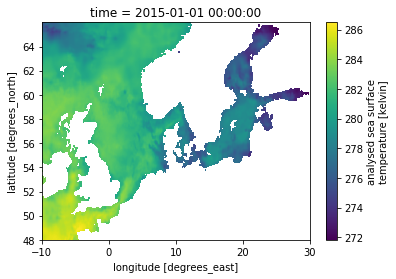

In [5]:
ds.analysed_sst[0].plot()

In [6]:
sst = ds.analysed_sst.values
sst.shape

(1, 600, 1334)

The input dataset dimensions are ordered (time, lon, lat).

This is the expected order

But the image have to be flipped upside down.

In [7]:
import numpy as np

sst[0] = np.flipud(sst[0])

## Coordinates

In [8]:
lat = ds.lat.values
lon = ds.lon.values


nx = len(lon)
ny = len(lat)

x0 = lon[0]
y0 = lat[0]


dx = (lon[-1] - lon[0]) / nx
dy = (lat[-1] - lat[0]) / ny

x0, y0, nx, ny, dx, dy

(-9.99, 48.01, 1334, 600, 0.029977509643005645, 0.029949995676676434)

## Time

In [9]:
print(ds.time.values[0])

2015-01-01 00:00:00


In [12]:
from datetime import datetime
start_time = datetime(2015,1,1)

## Variable types

In [13]:
from mikeio.eum import EUMType, EUMUnit

EUMType.Temperature

Temperature

In [14]:
EUMType.Temperature.units

[degree Celsius, degree Fahrenheit, degree Kelvin]

## Create dfs2

In [15]:
from mikeio import Dfs2
from mikeio.eum import ItemInfo

d = [sst]

dfsfilename = filename.replace(".nc", ".dfs2")

coordinate = ['LONG/LAT', x0, y0, 0]

dfs = Dfs2()
dfs.write(filename=dfsfilename,
           data=d,
           start_time = start_time, 
           coordinate=coordinate, dx=dx, dy=dy,
           items=[ItemInfo("Sea surface temperature", EUMType.Temperature, EUMUnit.degree_Kelvin)]
)

# Dfs2

![dfs2](../images/sst_dfs2.png)

# Clean up

In [17]:
import os
ds.close()
os.remove(gzfilename)
os.remove(filename)
os.remove(dfsfilename)